# Support Vector Machine - SVC: C-Support Vector Classification
## Referrences:
* https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
* https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
* https://www.kaggle.com/joshuaisanan/income-classification-grbf-kernel-svm-eda
* https://www.kaggle.com/dejavu23/titanic-survival-seaborn-and-ensembles

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns 

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
# from sklearn.linear_model import Perceptron
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV

from sklearn.metrics import classification_report, accuracy_score

def show_curve(train_sizes, train_scores, test_scores, title, xlabel='Training Size', ylabel='Score'):
  train_scores_mean= np.mean(train_scores, axis=1)
  train_scores_std= np.std(train_scores, axis=1)
  test_scores_mean= np.mean(test_scores, axis=1)
  test_scores_std= np.std(test_scores, axis=1)

  plt.plot(train_sizes, train_scores_mean, marker='o', label= "Training score")
  plt.plot(train_sizes, test_scores_mean, marker='o', label="Cross-Validation score")

  plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,color= '#33F4FF',alpha=0.5)
  plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, color= '#DDDDDD',alpha=0.5)

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(loc= 'best')


## Load data

* using skipinitialspace to remove extra space
* using na_value to see ? as NA

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', skipinitialspace=True, na_values="?")
# df  = pd.read_csv("../input/adult-census-income/adult.csv", skipinitialspace=True, na_values="?")
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 
                     'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                     'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

## Split data and Choose Features

In [3]:
from sklearn.model_selection import train_test_split

df.income = df.income.apply(lambda x: 0 if x=='<=50K' else 1)

# Pick discussed features
X = df.drop(['income'], axis=1)

# Pick the labels (Income)
y = df['income']

# Spliting into 80% for training set and 20% for testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))


22792
22792
9768
9768


In [4]:
DUMMIES_COLS = ['race', 'workclass', 'marital_status', 'occupation', 'relationship', 'sex']
DROP_COLS = ['fnlwgt', 'native_country', 'education']

X_train2 = X_train.copy()
X_train2 = pd.get_dummies(X_train2, columns=DUMMIES_COLS)
# X_train2.columns
X_train2 = X_train2.drop(DROP_COLS, axis=1)
y_train2 = y_train.copy()


X_test2 = pd.get_dummies(X_test, columns=DUMMIES_COLS)
X_test2 = X_test2.drop(DROP_COLS, axis=1)

# df2

In [5]:
# Find best features
from sklearn.feature_selection import SelectPercentile, chi2

test = SelectPercentile(score_func=chi2, percentile=16)
fit = test.fit(X_train2, y_train2)

X_train2.columns[test.get_support()]


Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'marital_status_Married-civ-spouse',
       'marital_status_Never-married', 'relationship_Husband'],
      dtype='object')

In [66]:
useBestFeature = False
if useBestFeature:
    SELECTED_COLS = X_train2.columns[test.get_support()]
    X_train2 = X_train2[SELECTED_COLS]
    X_test2 = X_test2[SELECTED_COLS]
    print('Use best features')


# Use SVM
Based on tutorial from page https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

And: https://www.kaggle.com/joshuaisanan/income-classification-grbf-kernel-svm-eda

## 1. Use LinearSVC

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

SVCpipe = Pipeline([('scale', StandardScaler()),
                   ('SVC',LinearSVC(max_iter = 10000, dual=False))])

gamma_vals = [0.001, 0.0001, 'scale']
param_grid = {'SVC__C':np.arange(0.01,100,10)}

linearSVC  = GridSearchCV(SVCpipe, param_grid=param_grid, cv=5, return_train_score=True)
linearSVC.fit(X_train2, y_train2.values.ravel())

print("The best parameters are %s with a score of %0.2f"
      % (linearSVC.best_params_, linearSVC.best_score_))

The best parameters are {'SVC__C': 10.01} with a score of 0.85


In [68]:
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
# clf = make_pipeline(StandardScaler(), LinearSVC(max_iter = 10000, C=10.01, dual=False))
clf = linearSVC.best_estimator_
clf.fit(X_train2, y_train2)


Pipeline(steps=[('scale', StandardScaler()),
                ('SVC', LinearSVC(C=10.01, dual=False, max_iter=10000))])

In [69]:
# Predict
y_pred = clf.predict(X_test2)

In [70]:
#Confusion Matrix
#The result is telling us that we have 6949+1380 correct predictions and 511+928 incorrect predictions.
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6949  511]
 [ 928 1380]]


In [71]:
print(classification_report(y_test, y_pred, target_names=['Income more than 50K', 'Income less than 50K']))
print("Accuracy:", accuracy_score(y_test, y_pred))

precision    recall  f1-score   support

Income more than 50K       0.88      0.93      0.91      7460
Income less than 50K       0.73      0.60      0.66      2308

            accuracy                           0.85      9768
           macro avg       0.81      0.76      0.78      9768
        weighted avg       0.85      0.85      0.85      9768

Accuracy: 0.8526822276822277


### Learning Curve

Learning curve for this LinearSVC - SVM model


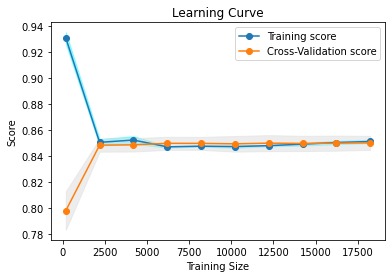

In [72]:
# Learning curve
train_size=np.linspace(0.01, 1, 10)

train_sizes, train_scores, test_scores = learning_curve(clf, X_train2, y_train2, train_sizes=train_size, scoring='accuracy')
show_curve(train_sizes, train_scores, test_scores, 'Learning Curve')

print('Learning curve for this LinearSVC - SVM model')

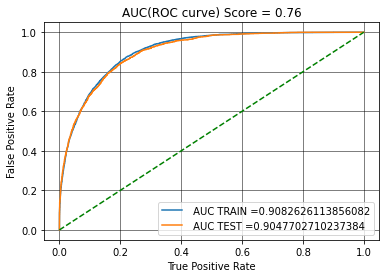

In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_train_pred = clf.decision_function(X_train2)    
y_test_pred = clf.decision_function(X_test2)

roc_auc = roc_auc_score(y_test, clf.predict(X_test2))

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train2, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC(ROC curve) Score = %0.2f" % roc_auc)
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

## 2. Use Kernelized SVM 

 using grid search to find the optimal hyperparameters.

In [73]:
notFoundBestGridParams = 0
best_params = {}

if notFoundBestGridParams == 1:
    C_range = [0.1, 1, 10, 100]
    gamma_vals = [0.001, 0.0001, 'scale']
    param_grid = dict(gamma=gamma_vals, C=C_range)

    grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=10)
    grid.fit(X, Y.values.ravel())
    
    best_params = grid.best_params_
    print("The best parameters are %s" % (grid.best_params_, grid.best_score_))
    
    svmModel = grid.best_estimator_
else:
    # we found that C = 10 and grammar = 'scale' is the best
    svmModel = Pipeline([('scale', StandardScaler()),
                   ('SVC',SVC(kernel='rbf', C = 10, gamma = 'scale'))])

# svmModel = SVC(kernel='rbf', C = 10, gamma = 'scale')
svmModel.fit(X_train2, y_train2)
y_pred2 = svmModel.predict(X_test2)


In [75]:
# print('Accuracy on test set: {:.5f}'.format(svmModel.score(X_test2, y_test)))
print(classification_report(y_test, y_pred2, target_names=['Income more than 50K', 'Income less than 50K']))
print("Accuracy:", accuracy_score(y_test, y_pred2))

precision    recall  f1-score   support

Income more than 50K       0.88      0.92      0.90      7460
Income less than 50K       0.70      0.61      0.65      2308

            accuracy                           0.85      9768
           macro avg       0.79      0.76      0.78      9768
        weighted avg       0.84      0.85      0.84      9768

Accuracy: 0.8466420966420967


### Learning curve

Learning curve for this SVM model


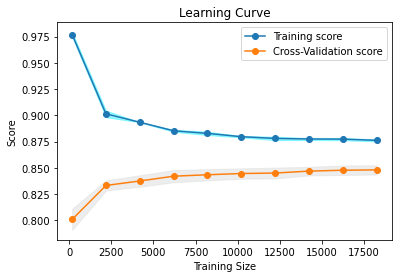

In [17]:
# Learning curve
train_size=np.linspace(0.01, 1, 10)

train_sizes, train_scores, test_scores = learning_curve(svmModel, X_train2, y_train2, train_sizes=train_size, scoring='accuracy')
show_curve(train_sizes, train_scores, test_scores, 'Learning Curve')

print('Learning curve for this Kernelized SVM model')

## Validation curve

In [35]:
param_range = np.linspace(0.01, 1, 10)
    
train_scores, test_scores = validation_curve(svmModel, X_train2, y_train2, param_name="SVC__C", param_range=param_range, scoring="accuracy")
show_curve(param_range, train_scores, test_scores, 'Validation Curve')

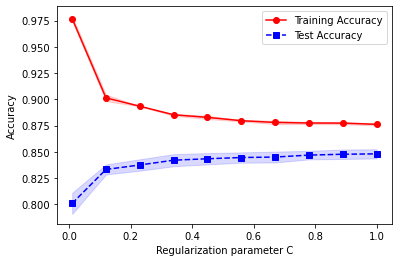

In [20]:
# Mean value of accuracy against training data
train_mean = np.mean(train_scores, axis=1)

# Standard deviation of training accuracy per number of training samples
train_std = np.std(train_scores, axis=1)

# Same as above for test data
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot training accuracies 
plt.plot(param_range, train_mean, color='red', marker='o', label='Training Accuracy')
# Plot the variance of training accuracies
plt.fill_between(param_range,train_mean + train_std, train_mean - train_std, alpha=0.15, color='red')

# Plot for test data as training data
plt.plot(param_range, test_mean, color='blue', linestyle='--', marker='s', label='Test Accuracy')
plt.fill_between(param_range,test_mean + test_std, test_mean - test_std, alpha=0.15, color='blue')

plt.xlabel('Regularization parameter C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 3. Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=10)
rf_clf.fit(X_train2, y_train2)

y_pred3 = rf_clf.predict(X_test2)

In [7]:
print(classification_report(y_test, y_pred3, target_names=['Income more than 50K', 'Income less than 50K']))
print("Accuracy:", accuracy_score(y_test, y_pred3))

                      precision    recall  f1-score   support

Income more than 50K       0.89      0.94      0.91      7460
Income less than 50K       0.76      0.63      0.69      2308

            accuracy                           0.86      9768
           macro avg       0.83      0.78      0.80      9768
        weighted avg       0.86      0.86      0.86      9768

Accuracy: 0.8648648648648649


Learning curve for this Random Forest model


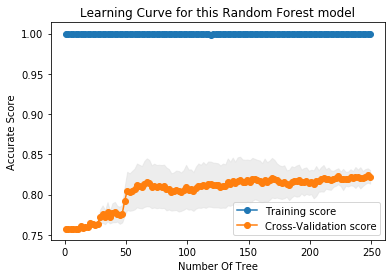

In [8]:
# Learning curve
train_size=np.arange(1, 250, 2)
# np.linspace(0.01, 1, 20)

train_sizes, train_scores, test_scores = learning_curve(rf_clf, X_train2, y_train2, train_sizes=train_size, scoring='accuracy')
show_curve(train_sizes, train_scores, test_scores, 'Learning Curve for this Random Forest model', "Number Of Tree", 'Accurate Score')

print('Learning curve for this Random Forest model')

In [ ]:
# param_range = np.arange(1, 250, 2)
# np.linspace(1, 10, 100)
    
train_scores, test_scores = validation_curve(rf_clf, X_train2, y_train2, param_name="n_estimators", param_range=param_range, cv=4, scoring="accuracy", n_jobs=-1)
show_curve(train_sizes, train_scores, test_scores, 'Learning Curve for this Random Forest model', "Number Of Tree", 'Accurate Score')

## 4. Voting Boosting and RF

In [ ]:
clf4 = GradientBoostingClassifier()
clf5 = SVC()
clf6 = RandomForestClassifier()

eclf_2 = VotingClassifier(estimators=[('gbdt', clf4), 
                                      ('svc', clf5), 
                                      ('rf', clf6)], voting='soft')

params = {'gbdt__n_estimators': [50], 'gbdt__min_samples_split': [3],
          'svc__C': [10, 100] , 'svc__gamma': [0.1,0.01,0.001] , 'svc__kernel': ['rbf'] , 'svc__probability': [True],  
          'rf__max_depth': [7], 'rf__max_features': [2,3], 'rf__min_samples_split': [3] } 

# with ignore_warnings(category=DeprecationWarning):
votingclf_grid_2 = GridSearchCV(estimator=eclf_2, param_grid=params, cv=10)
votingclf_grid_2.fit(X_train2,y_train2)
    

In [ ]:
y_pred4 = votingclf_grid_2.predict(X_test2)

In [ ]:
print(classification_report(y_test, y_pred4, target_names=['Income more than 50K', 'Income less than 50K']))
print("Accuracy:", accuracy_score(y_test, y_pred4))